In [1]:
import pandas as pd
import numpy as np
import matplotlib
import pylab as pl
import matplotlib.pyplot as plt

from collections import defaultdict

Purpose of Project: 

Process spreadsheets full of FCQ course information. Had to:
-Process course names into needed form for cross-lookup
-Map newly processed course names into courselearning outcomes
-Confirm any missing or erroneous data
-Calculate new FCQ score
-Change from dictionary to pandas df for plotting
-Create example graphs for courses of FCQ score by semester



In [2]:
def process_fcq_spreadsheet(filename):
    xls = pd.ExcelFile(filename)
    fcq_datasheet_dict = {}
    for sheet_name in xls.sheet_names:
        fcq_datasheet_dict[sheet_name] = xls.parse(sheet_name)
    return fcq_datasheet_dict, xls.sheet_names


def process_fcq_sheet(df):

    # Keep only the ELEC courses, drop all other departments 
    # May need to grab data for ENGR3400
    searchfor = ['ELEC']
    df = df[df['Course Section Label'].str.contains('|'.join(searchfor))]
    df = df.dropna(how='all', axis=1)
    
    # Only process the course results (Not the instructor results)
    # ABET outcomes from custom questions are part of "Course Section Results"
    indexNames = df[(df['Instructor'] != 'Course Section Results')].index 
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    
    
    return df



In [3]:

def process_get_custom_columns_from_dataframe(df, course):

    list_of_cols = df[df['Course Section Label'] == course].columns.values.tolist()

    # Take away the main
    list_of_col = [item for item in list_of_cols if item not in ['Course Section Label', 'Institutional Unit', 'Instructor']]

    # Only include columns that have speial designation
    list_of_cols = [item for item in list_of_cols if '-elec-' in item]

    #print(list_of_cols)

    custom_questions = dict()
    for col in list_of_cols:
        stop_df = df[df['Course Section Label'] == course]

        stop_df = stop_df[col]

        if stop_df.shape[0] != 0 and not np.isnan(stop_df.mean()) :
           #print (stop_df)
           #print (course, col,  stop_df.mean(skipna = True))
           custom_questions[col] = stop_df.mean(skipna = True)
        
    return custom_questions

def process_semester_dataframe(sheet_to_df_map, semester):
    
    print ("processing ", semester)
    df = process_fcq_sheet(sheet_to_df_map[semester])

    course_list = df['Course Section Label'].unique()
    
    course_custom_dict = defaultdict(dict)
            
    

    #mini_df = df[df['Course Section Label'] == 'ELEC 1520(001): Embedded Systems Engr I']
        
    
    for course in course_list:
            custom_questions = process_get_custom_columns_from_dataframe(df, course)
            course_custom_dict[course] = custom_questions
            #print(custom_questions)
        

    return course_custom_dict


In [4]:

# Open the entire spreadsheet file and 
fcq_datasheet_dict, semester_list = process_fcq_spreadsheet('CustomQuestions.xlsx')

#process_semester_dataframe(fcq_datasheet_dict, '2019_Fall') 


#process_semester_dataframe(fcq_datasheet_dict, '2018_Fall')

fcq_data_semester_course_custom = dict()

#semester_list = ['2019_Fall']
for semester in semester_list:
    fcq_data_semester_course_custom[semester] = process_semester_dataframe(fcq_datasheet_dict, semester)
    


#print (fcq_data_semester_course_custom)


processing  2017_Fall
processing  2018_Spring
processing  2018_Summer
processing  2018_Fall
processing  2019_Spring
processing  2019_Summer
processing  2019_Fall


In [5]:

#Example of one course and seeing custom question outcomes
# Need to map these to course learning outcomes
# We may just use numberin starting from CO-1, CO-2, since questions may be in order. 

print (fcq_data_semester_course_custom['2019_Fall']['ELEC 4727(001): Comp Vis & Image Proc Acc'])


{'dn-a-elec-bm Question #246: DN-A-ELEC-BM02. Calculate the image results of computer vision and image processing algorithms on image input datasets. ': 4.0, 'dn-a-elec-bm Question #247: DN-A-ELEC-BM03. Develop computer vision programs using OpenCV library tools. ': 3.0, 'dn-a-elec-bm Question #248: DN-A-ELEC-BM04. Utilize cloud coding programming techniques to construct computer vision and machine learning algorithms. ': 2.0, 'dn-a-elec-bm Question #249: DN-A-ELEC-BM05. Develop Python codes to facilitate computer vision applications. ': 4.0, 'dn-a-elec-bm Question #250: DN-A-ELEC-BM06. Analyze computer performance algorithms to identify bottlenecks and optimization opportunities. ': 2.0, 'dn-a-elec-bm Question #251: DN-A-ELEC-BM07. Implement and design machine learning algorithms to facilitate computer vision algorithms. ': 3.0}


In [6]:
#TASK1--Replace the long name with the short name
#Ex--ELEC 1201(001): Intro to Electrical Engineerng as ELEC1201

#TASK2--Change FCQ question to course learning objective number
#note to self--students are answering how well they fulfilled the course objective
#the student assessment

#TASK3--Drop courses which contain an empty dictionary from the data set

#TASK4--Calculate new score by dividing by 5 and multiplying by 100

#TASK5--Create example graph for Monday's presentation
#FCQ results over time, perhaps for a specific course

In [7]:
def cleanDict(fcqDict):
    
    #short dict will contain the cleaned up dictionary items,
    #reject dict will have all of the blanks
    shortDict = dict()
    rejectDict = dict()
    #go through each semester of the dict
    for semester in fcqDict:
        shortDict[semester] = dict()
        #go through each course in the semester
        for course in fcqDict[semester]:
            #if not empty, clean data
            if(bool(fcqDict[semester][course])):
                #split the string and change course to the trimmed version
                shortCourse = course.split('(')[0]

                #another dict inside these dicts for the question and score
                shortDict[semester][shortCourse] = dict()
                #we will enumerate each question, these are the course objectives, right?
                count = 0
                for question in fcqDict[semester][course]:
                    #print(question)
                    count+=1
                    stringQuestion = str(count) + ". "
                    shortQuestion = stringQuestion + question.split('.')[1]
                    #print(shortQuestion)

                    #change new dict
                    #make score out of 100 instead of 5
                    shortDict[semester][shortCourse][shortQuestion] = (fcqDict[semester][course][question]/5)*100
            #the else means there was a blank dict entry for the course and we will not put in cleaned dict
            #but instead put it in the reject dict
            else:
                rejectDict[semester] = course
                
    return shortDict, rejectDict


            

In [8]:
cleanDict, rejectDict = cleanDict(fcq_data_semester_course_custom)
#print(shortDict)
print(cleanDict['2019_Fall']['ELEC 4727'])
print(rejectDict)

#it works!!!

{'1.  Calculate the image results of computer vision and image processing algorithms on image input datasets': 80.0, '2.  Develop computer vision programs using OpenCV library tools': 60.0, '3.  Utilize cloud coding programming techniques to construct computer vision and machine learning algorithms': 40.0, '4.  Develop Python codes to facilitate computer vision applications': 80.0, '5.  Analyze computer performance algorithms to identify bottlenecks and optimization opportunities': 40.0, '6.  Implement and design machine learning algorithms to facilitate computer vision algorithms': 60.0}
{'2017_Fall': 'ELEC 4174(001): Power Electronic Systems', '2018_Spring': 'ELEC 5667(001): Wavelet Theory-Applicatio', '2018_Summer': 'ELEC 4800(001): Special Topics', '2018_Fall': 'ELEC 5133(001): Electrmagntc Radiation-Antenna', '2019_Spring': 'ELEC 5755(001): Renewable Energy Systems', '2019_Fall': 'ELEC 5375(001): Engineering Neuroscience'}


In [9]:
def plotFCQ(fcqDict, course):
    plotdf = pd.DataFrame()
    xNan = float('nan')
    numObjectives = 0
    scoresDict = {}
    scoresdf = pd.DataFrame()
    
    #basically here we are
    #creating a list of semesters
    #making a new dictionary thats more simple of the questions and each of the scores
    #filtering out any nan scores and making them 0
    semesters = []
    for semester in fcqDict:
        for coarse in fcqDict[semester]:
            if(coarse==course):
                #it looks like the semesters are in order for these fcqs so im just gonna go with it and make a lil list
                if semester not in semesters:
                    semesters.append(semester)

                for question in fcqDict[semester][course]:
                    #filtering nans and adding to new dict here
                    #is the new dict necessary? idk but it's in my old code so i'll roll with it 
                    try:
                        val = round(fcqDict[semester][course][question],2)
                        if(val==np.nan):
                            val = 0
                        if question in scoresDict.keys():
                            scoresDict[question].append(val)
                        else:
                            scoresDict[question]=[val]
                    except:
                        print("Error with scoresDict")

                
    #print(semesters)
    #now start messin with pandas df to get ready for plotting
    scoresdf = pd.DataFrame(data=scoresDict)
    scoresdf.index = semesters
    #print(scoresdf)
    
    #plot and put legend to the left of the graph
    plot = scoresdf.plot(marker='o', title=course)
    plot.legend(loc="center left", bbox_to_anchor=(1, .5), ncol=2)
                    
            
                
    
        

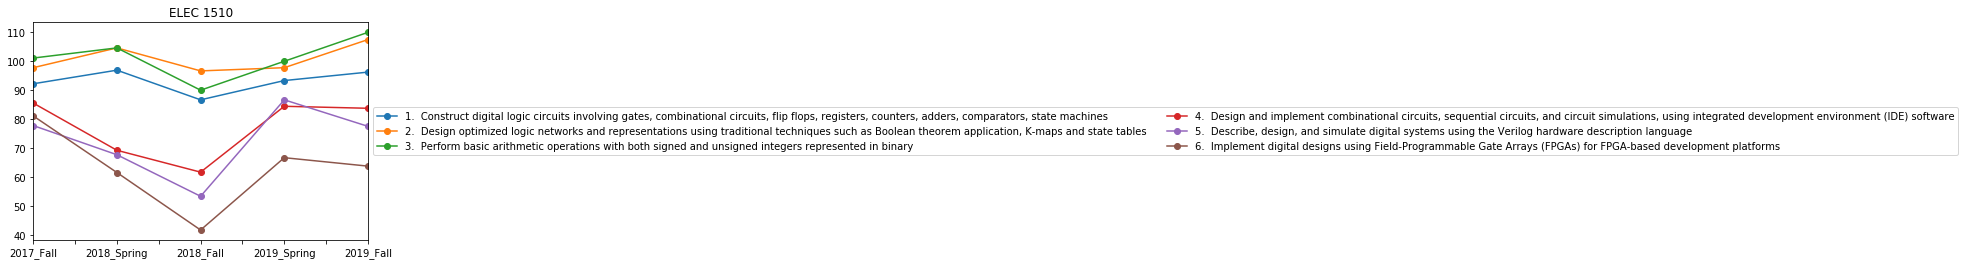

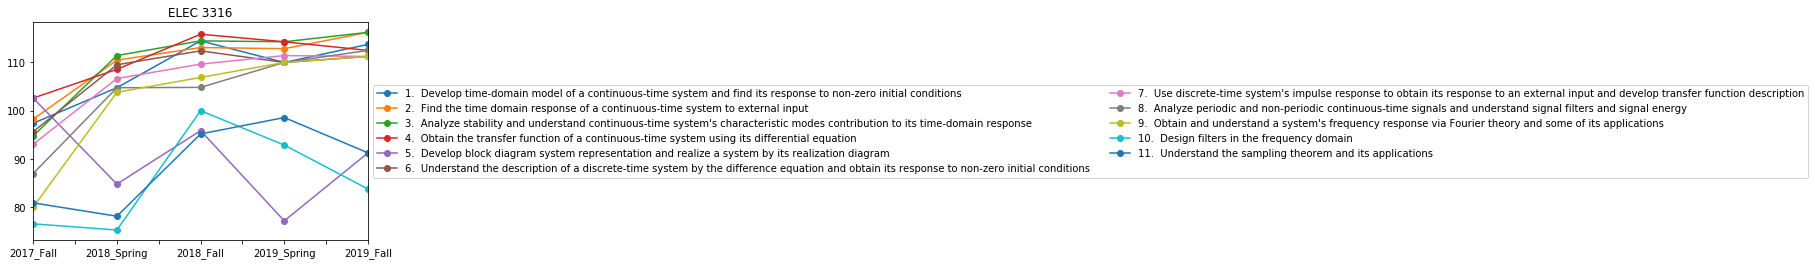

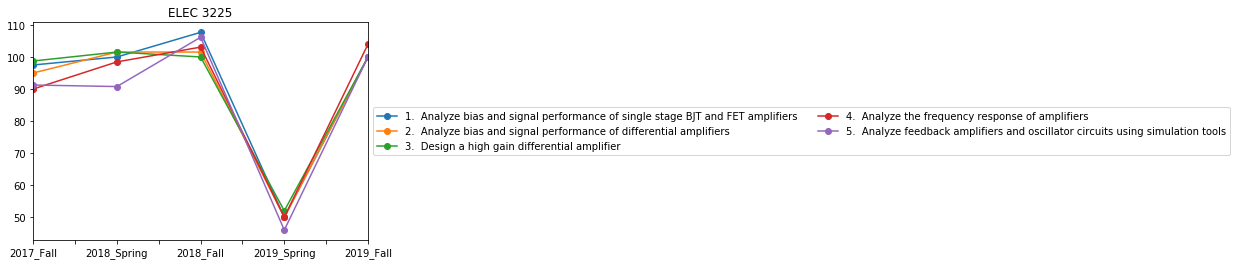

In [10]:
#plotFCQ(shortDict, "ELEC 4727")
plotFCQ(cleanDict, "ELEC 1510")
plotFCQ(cleanDict, "ELEC 3316")
plotFCQ(cleanDict, "ELEC 3225")